# sklearn/SVM tuning with MNIST

## Libraries

In [1]:
# libraries
#using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
#using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


## Functions

In [2]:
image2Vector(M) = vec( Float32.(M) )   # 32-bits is faster on GPU

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2Matrix(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    M'
end

function batchImage2DF(imagesArray3D)
    M = batchImage2Matrix(imagesArray3D)
    DataFrame(M, :auto)
end


batchImage2DF (generic function with 1 method)

In [3]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    acc = accuracy(ŷ, y)
    f1  = multiclass_f1score(ŷ, y)
    println("accuracy: ", round(acc; digits=3))
    println("f1-score: ", round(f1;  digits=3))
    
    return (acc, f1)
end


printMetrics (generic function with 1 method)

## Dataset

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata()

# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)


((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocess


In [5]:
function preprocess(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocess(trainX, trainY);

In [6]:
scitype(X)

Table{AbstractVector{Continuous}}

In [7]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Pipe the model

In [8]:
# standardize predictors
std = Standardizer()

# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.9)

# svm scikitlearn
SVMClass = @load SVMClassifier pkg="ScikitLearn" verbosity=0
svm = SVMClass()

pipe = @pipeline reducer std svm


Pipeline291(
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.9,
            mean = nothing),
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    svm_classifier = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 200,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing))

### Train

In [9]:
mach = MLJ.machine(pipe, X, y) |> fit! #(acceleration=CPUProcesses())     # not supported yet


┌ Info: Training Machine{Pipeline291,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{SVMClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


Machine{Pipeline291,…} trained 1 time; caches data
  model: Pipeline291
  args: 
    1:	Source @169 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @382 ⏎ `AbstractVector{OrderedFactor{10}}`


In [10]:
ŷ = MLJ.predict(mach, X);
ŷ[1:5]


5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 8
 2
 6
 2
 7

In [11]:
accTrain, f1Train = printMetrics(ŷ, y);


10×10 Matrix{Int64}:
 4141     1     2     0     0     2     2     1     0     2
    0  4696     3     2     4     0     0    12     5     0
    0    10  4155     6     1     1     0     4     4     0
    0     1     0  4259     0     7     0     0     1     2
    1     2     5     0  4063     1     2     6     2    14
    0     0     0     7     0  3775     0     0     4     1
    3     0     0     0     4     5  4137     0     0     0
    0     4     3     9     1     0     0  4351     2    11
    0     2     3     4     1     2     2     2  4075     1
    1     3     0     5    15     2     0    10     3  4133

accuracy: 0.995
f1-score: 0.995


### Evaluate

The machine model obtained is now evaluated for accuracy and f1 through cross-validdation with the trainset.

#### Single parameter

#### Multiple parameters

In [12]:
meas = [accuracy, multiclass_f1score]
cv   = CV(nfolds=10)

evaluationResult = MLJ.evaluate(pipe, X, y,
                   resampling=cv,
                   measure=meas,
                   acceleration=CPUThreads(),
                   verbosity=0)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────────────────────────────────────────────────────────┬─────
│ measure                                                                 │ me ⋯
├─────────────────────────────────────────────────────────────────────────┼─────
│ Accuracy()                                                              │ 0. ⋯
│ MulticlassFScore(β = 1.0,average = MacroAvg(),return_type = LittleDict) │ 0. ⋯
└─────────────────────────────────────────────────────────────────────────┴─────
                                                               3 columns omitted


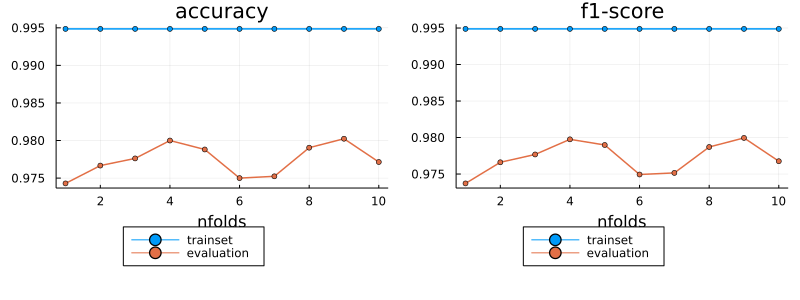

In [13]:
xs = 1:10

# accuracy
ys = repeat([accTrain], 10)
ys = hcat(ys, evaluationResult.per_fold[1])
p1 = plot(xs, ys, title="accuracy")

# f1
ys = repeat([f1Train], 10)
ys = hcat(ys, evaluationResult.per_fold[2])
p2 = plot(xs, ys, title="f1-score")
     
# plots
plot(p1, p2, layout = (1, 2), size=(800,300),
     label=["trainset" "evaluation"],
     xlabel="nfolds",
     linewidth=1.5,
     markershape=:circle,
     markersize=3,
     legend=:outerbottom)

### Tuning

In [14]:
r = range(pipe, :(svm_classifier.C), lower=1e-3, upper=1.0, scale=:log)

NumericRange(0.001 ≤ svm_classifier.C ≤ 1.0; origin=0.5005, unit=0.4995) on log scale

In [15]:
cv   = CV(nfolds=3)

selfTuningPipe = TunedModel(model=pipe,
                            resampling=cv,
                            tuning=Grid(resolution=3),
                            range=r,
                            measure=accuracy,
                            acceleration=CPUThreads())

DeterministicTunedModel(
    model = Pipeline291(
            pca = PCA,
            standardizer = Standardizer,
            svm_classifier = SVMClassifier),
    tuning = Grid(
            goal = nothing,
            resolution = 3,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 3,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = Accuracy(),
    weights = nothing,
    operation = nothing,
    range = NumericRange(0.001 ≤ svm_classifier.C ≤ 1.0; origin=0.5005, unit=0.4995) on log scale,
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

In [16]:
mach = machine(selfTuningPipe, X, y) |> fit! #(acceleration=CPUProcesses())     # not supported yet


┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Attempting to evaluate 3 models.
└ @ MLJTuning /home/ciro/.julia/packages/MLJTuning/Al9yX/src/tuned_models.jl:680
Evaluating over 3 metamodels: 100%[=========================] Time: 0:14:27


Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, Pipeline291}
  args: 
    1:	Source @516 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @218 ⏎ `AbstractVector{OrderedFactor{10}}`


In [17]:
# best parameter for the search
println("Best C: ", fitted_params(mach).best_model.svm_classifier.C)

Best C: 1.0
